In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [9]:
subdirectories = os.listdir('images/train')
subdirectories

['butterfly', 'cat', 'dog', 'elephant', 'horse']

In [9]:
sizes_count =  dict()

for dir in subdirectories:
    dir_path = os.path.join('images/train', dir)
    files = os.listdir(dir_path)
    print(dir_path)
    for file in files:
        image = cv2.imread(os.path.join(dir_path, file))
        shape = image.shape
        if shape in sizes_count:
            sizes_count[shape] += 1
        else:
            sizes_count[shape] = 1

images/train\butterfly
images/train\cat
images/train\dog
images/train\elephant
images/train\horse


In [6]:
X = list()
y = list()

for dir in subdirectories:
    dir_path = os.path.join('images/train', dir)
    files = os.listdir(dir_path)
    print(dir_path)
    for file in files:
        image = cv2.imread(os.path.join(dir_path, file))

        image_reshaped = cv2.resize(image, (256,256))
        target = image_reshaped[112:144, 112:144].copy()
        image_reshaped[112:144, 112:144] = 0

        X.append(image_reshaped)
        y.append(target)


images/train\butterfly
images/train\cat
images/train\dog
images/train\elephant
images/train\horse


In [10]:
X_test = list()
y_test = list()



for dir in subdirectories:
    dir_path = os.path.join('images/test', dir)
    files = os.listdir(dir_path)
    print(dir_path)
    for file in files:
        image = cv2.imread(os.path.join(dir_path, file))

        image_reshaped = cv2.resize(image, (256,256))
        target = image_reshaped[112:144, 112:144].copy()
        image_reshaped[112:144, 112:144] = 0

        X_test.append(image_reshaped)
        y_test.append(target)
        


images/test\butterfly


images/test\cat
images/test\dog
images/test\elephant
images/test\horse


In [7]:
X = np.array(X)
y = np.stack(y)

In [11]:
X_test = np.array(X_test)
y_test = np.stack(y_test)

In [99]:
X.shape

(9154, 256, 256, 3)

In [100]:
y.shape

(9154, 32, 32, 3)

In [10]:
X_test.shape

(1014, 256, 256, 3)

In [9]:
n = X.shape[0]
X_train = X[:int(n*0.9)]
X_val = X[int(n*0.9):]
y_train = y[:int(n*0.9)]
y_val = y[int(n*0.9):]

In [11]:
from sklearn.preprocessing import MinMaxScaler

from joblib import dump


X_train_reshaped = X_train.reshape((-1, 3))
X_val_reshaped = X_val.reshape((-1, 3))

scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_x.fit(X_train_reshaped)
dump(scaler_x, 'scaler_x.joblib')


['scaler_x.joblib']

In [14]:
from joblib import load
scaler_x = load('scaler_x.joblib')


In [ ]:

X_train_scaled = scaler_x.transform(X_train_reshaped).reshape(-1, 256, 256, 3)
X_val_scaled = scaler_x.transform(X_val_reshaped).reshape(-1, 256, 256, 3)

In [103]:
for i in range(X_train_scaled.shape[0]):
    np.save(f'train_x/{i}', X_train_scaled[i])

for i in range(X_val_scaled.shape[0]):
    np.save(f'val_x/{i}', X_val_scaled[i])


In [104]:
X_train_scaled = None
X_val_scaled = None

In [15]:

X_test_reshaped = X_test.reshape((-1, 3))

X_test_scaled = scaler_x.transform(X_test_reshaped).reshape(-1, 256, 256, 3)


In [13]:
y_train_reshaped = y_train.reshape((-1, 3))
y_val_reshaped = y_val.reshape((-1, 3))

scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_y.fit(y_train_reshaped)
dump(scaler_y, 'scaler_y.joblib')


['scaler_y.joblib']

In [16]:
scaler_y = load('scaler_y.joblib')

In [ ]:

y_train_scaled = scaler_y.transform(y_train_reshaped).reshape(-1, 32, 32, 3)
y_val_scaled = scaler_y.transform(y_val_reshaped).reshape(-1, 32, 32, 3)



In [107]:
for i in range(y_train_scaled.shape[0]):
    np.save(f'train_y/{i}', y_train_scaled[i])

for i in range(y_val_scaled.shape[0]):
    np.save(f'val_y/{i}', y_val_scaled[i])

In [108]:
y_train_scaled = None
y_val_scaled = None

In [19]:
y_test.shape

(1014, 32, 22, 3)

In [22]:
y_test_reshaped = y_test.reshape((-1, 3))

y_test_scaled = scaler_y.transform(y_test_reshaped).reshape(-1, 32, 32, 3)

In [2]:
import numpy as np
from tensorflow.keras.utils import Sequence


class data_generator():

    def __init__(self, train=True, batch_size = 32):
        self.batch_size = batch_size
        if train:
            self.X_path = 'train_x'
            self.y_path = 'train_y'
        else:
            self.X_path = 'val_x'
            self.y_path = 'val_y'

        files = os.listdir(self.X_path)

        self.length = len(files)

    def __len__(self):
        return self.length


    def __getitem__(self, index):
            filename = f'{index}.npy'
            X = np.load(os.path.join(self.X_path, filename))
            y = np.load(os.path.join(self.y_path, filename))

            return X, y
    

# Example usage:
batch_size = 32
train_generator = data_generator(batch_size)
val_generator = data_generator(train=False ,batch_size=batch_size)



In [3]:
train_data_generator = data_generator(train=True, batch_size=32)
val_data_generator = data_generator(train=False, batch_size=32)

# Define a function to yield batches of data
def data_generator_function():
    for i in range(len(train_data_generator)):
        yield train_data_generator[i]

def data_generator_function_val():
    for i in range(len(val_data_generator)):
        yield val_data_generator[i]

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_generator(
    data_generator_function,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32)
    )
)

dataset_val = tf.data.Dataset.from_generator(
    data_generator_function_val,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32)
    )
)

# Batch and prefetch the dataset
batched_dataset = dataset.batch(train_data_generator.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
batched_dataset_val = dataset_val.batch(train_data_generator.batch_size).prefetch(tf.data.experimental.AUTOTUNE)



In [4]:
model = Sequential([
    Conv2D(4, (3,3), padding='same', activation='relu', input_shape=(256, 256, 3)),
    MaxPool2D(2,2),
    Conv2D(6, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Conv2D(8, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Conv2D(10, (3,3), padding='same', activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(8*8*8, activation='relu'),
    Reshape((8,8,8)),
    Conv2DTranspose(4, (3,3), padding='same', strides=(2,2)),
    Conv2DTranspose(3, (3,3), padding='same', strides=(2,2), activation='tanh')
])

model.summary()

output_shape = model.layers[-1].output_shape
print("Output shape of the specified layer:", output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 6)       222       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         440       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 8)         0

In [5]:
model.compile(
    loss='mse',
    optimizer = 'adam',
    metrics = 'mae'
)

In [6]:
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
model.fit(
    batched_dataset,
    epochs=20, 
    validation_data = batched_dataset_val,
    callbacks = []
    )

Epoch 1/20
258/258 [==============================] - 1576s 6s/step - loss: 0.1937 - mae: 0.3516 - val_loss: 0.1408 - val_mae: 0.2881
Epoch 2/20
258/258 [==============================] - 729s 3s/step - loss: 0.1179 - mae: 0.2615 - val_loss: 0.1170 - val_mae: 0.2569
Epoch 3/20
258/258 [==============================] - 707s 3s/step - loss: 0.1001 - mae: 0.2373 - val_loss: 0.1091 - val_mae: 0.2449
Epoch 4/20
258/258 [==============================] - 709s 3s/step - loss: 0.0925 - mae: 0.2269 - val_loss: 0.1082 - val_mae: 0.2431
Epoch 5/20
258/258 [==============================] - 747s 3s/step - loss: 0.0885 - mae: 0.2214 - val_loss: 0.1080 - val_mae: 0.2416
Epoch 6/20
258/258 [==============================] - 737s 3s/step - loss: 0.0854 - mae: 0.2172 - val_loss: 0.1079 - val_mae: 0.2400
Epoch 7/20
258/258 [==============================] - 729s 3s/step - loss: 0.0823 - mae: 0.2130 - val_loss: 0.1087 - val_mae: 0.2407
Epoch 8/20
258/258 [==============================] - 740s 3s/step -

In [7]:
model.save('model.h5')

c:\Users\krzysztof\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model = load_model('model.h5')



1/1 [==============================] - 1s 1s/step


In [17]:
y_pred = model.predict(X_test_scaled)

32/32 [==============================] - 44s 1s/step


In [18]:
y_to_display = scaler_y.inverse_transform(y_pred.reshape((-1, 3))).reshape((-1, 32, 32, 3))
y_to_display = y_to_display.astype(np.int32)
y_to_display[y_to_display > 255] = 255


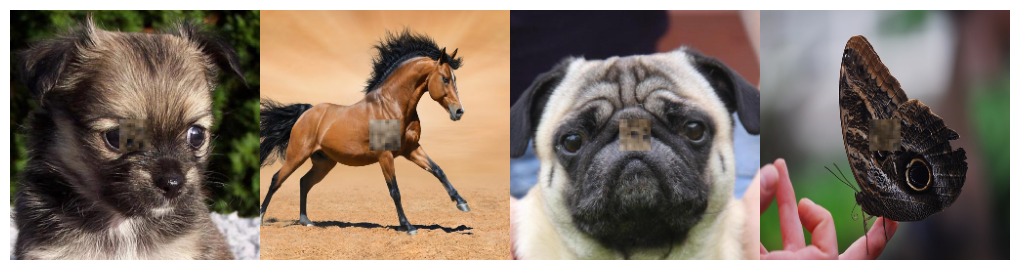

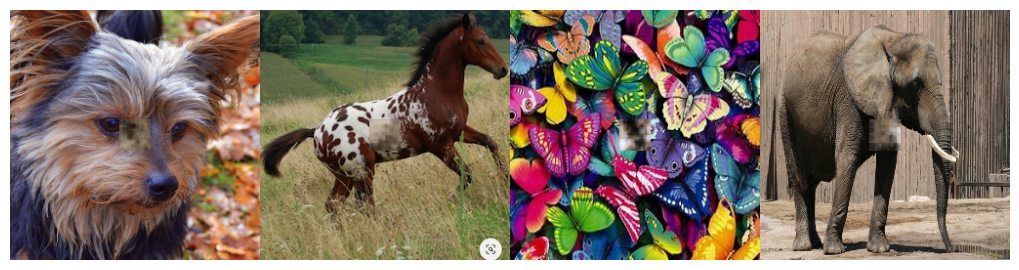

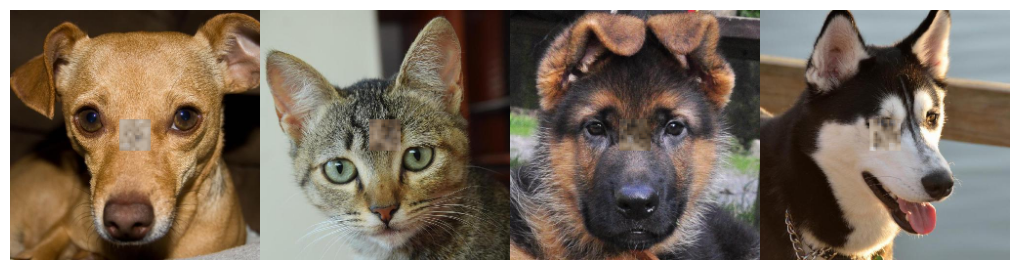

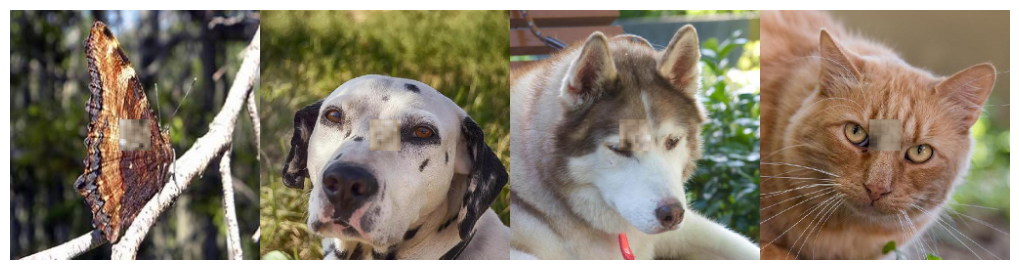

In [20]:


for j in range(4):
    indexes = np.random.randint(0, y_pred.shape[0], 4)
    fig, axes = plt.subplots(1, 4, figsize=(10, 3), gridspec_kw={'wspace': 0})
    for i in range(4):
        X_to_display = X_test[indexes[i]]
        X_to_display[112:144, 112:144] = y_to_display[indexes[i]]
        axes[i].imshow(cv2.cvtColor(X_to_display, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    plt.tight_layout(pad=0)

    plt.show()